In [1]:
#Imports
import json
import numpy as np
import pandas as pd
import csv
import scipy.stats
import matplotlib.pyplot as plt
import seaborn as sns
import os
from django.contrib.admin.utils import flatten
import pyhrv
import pyhrv.nonlinear as nl
import statistics

In [2]:
# Calcula el std de los mínimos porcentuales

# path = 'C:/Users/Leand/OneDrive/Documentos/Lean/Analizador_imagenes_calcio/Luis/analisis/'
path = '/media/leandro/Volumen1TB/Lean/Analizador_imagenes_calcio/Luis/analisis/'
experiments = os.listdir(path + 'jsons/')
min_exp = pd.DataFrame()
for i in range(0,len (experiments)):
    experiment = experiments[i]
    with open(path + 'jsons/' + experiment) as f:
        min_file = json.load(f)['image']['min_peaks_intensities']
        min_exp[i] = experiment,(np.array(min_file)*100/min_file[0]).std()
min_exp = pd.DataFrame (min_exp.T)
min_exp.columns = ['file','std_min']

In [49]:
# Extrae los mínimos por slice

# path = 'C:/Users/Leand/OneDrive/Documentos/Lean/Analizador_imagenes_calcio/Luis/analisis/'
path = '/media/leandro/Volumen1TB/Lean/Analizador_imagenes_calcio/Luis/analisis/'
experiments = os.listdir(path + 'jsons/')
min_exp = pd.DataFrame()
for i in range(0,len (experiments)):
    experiment = experiments[i]
    with open(path + 'jsons/' + experiment) as f:
        min_file = json.load(f)['image']['min_peaks_intensities']
        min_exp[i] = experiment,(np.array(min_file)*100/min_file[0])
min_exp = pd.DataFrame (min_exp.T)
min_exp.columns = ['file','mins']

/home/leandro/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [50]:
# Filtrado por tratamiento y frecuencia

def tau_filter(tratamiento,frecuencia,df):
    tabulado_filter = tabulado[(tabulado['tratamiento']==tratamiento) & (tabulado['frecuencia']== frecuencia)].reset_index(drop=True)
    tau = pd.DataFrame(columns = ['file','mins'])
    for j in range(0,len (tabulado_filter)):
        celula = tabulado_filter['célula'][j]
        foto = tabulado_filter['foto'][j][:-4]
        for i in range(0,len (df)):
            if (celula in df['file'][i]) & (foto in df['file'][i]):
                tau.loc[j] = df.loc[i]
    return tau

In [51]:
tabulado = pd.read_csv(path + 'tabulado')
del tabulado['Unnamed: 0']

In [55]:
tabulado_control5 = tau_filter('C', 5, min_exp)
tabulado_vk5 = tau_filter('VK', 5, min_exp)
tabulado_dan5 = tau_filter('DAN', 5, min_exp)

In [ ]:
tabulado_control5.drop(3, inplace=True)

In [9]:
def outliers(column):
    Q1 = column.quantile(0.25)
    Q3 = column.quantile(0.75)
    IQR = Q3 - Q1
    idx = ~((column < (Q1 - 1.5 * IQR)) | (column > (Q3 + 1.5 * IQR)))
    return idx

In [ ]:
tabulado_control5 = tabulado_control5[outliers(tabulado_control5['std_min'])]
tabulado_vk5 = tabulado_vk5[outliers(tabulado_vk5['std_min'])]
tabulado_dan5 = tabulado_dan5[outliers(tabulado_dan5['std_min'])]

In [ ]:
df = pd.concat ([tabulado_control5,tabulado_vk5,tabulado_dan5], axis=1, sort=False, keys=['C', 'VK','DAN'])
df
sns.set(style="ticks")

# Initialize the figure with a logarithmic x axis
f, ax = plt.subplots(figsize=(7, 6))


sns.boxplot(data=df)

sns.swarmplot(data=df, linewidth=2)
f.savefig("std_min%.png")

In [ ]:
df.to_excel('std_min%.xlsx', engine = 'xlsxwriter')

In [ ]:
print(scipy.stats.kstest(tabulado_control5['std_min'],tabulado_dan5['std_min']))
print(scipy.stats.kstest(tabulado_control5['std_min'],tabulado_vk5['std_min']))
print(scipy.stats.kstest(tabulado_vk5['std_min'],tabulado_dan5['std_min']))
print(scipy.stats.shapiro(tabulado_control5['std_min']))

In [ ]:
DI_control = pd.read_csv(path + 'DI_control.csv')

In [ ]:
min5 = []
for i in range(0,len(DI_control['file'])):
    cel = DI_control['file'][i]
    filtro_wc5 = tabulado_control5[(tabulado_control5['file'].str.contains(cel) == True)]
    min5.append (filtro_wc5['std_min'].values)
DI_control['min5'] = min5

In [ ]:
DI_control.drop(4, inplace=True)
DI_control.drop(5, inplace=True)
DI_control.drop(6, inplace=True)
DI_control.drop(9, inplace=True)
DI_control.drop(21, inplace=True)
b = [j for i in DI_control['min5'].tolist() for j in i]
a = DI_control['DISCORDANCE 5 Hz']

In [ ]:
from scipy.stats.stats import pearsonr 
print (pearsonr(DI_control['DISCORDANCE 5 Hz'],b))

In [ ]:
plt.scatter(a,b)

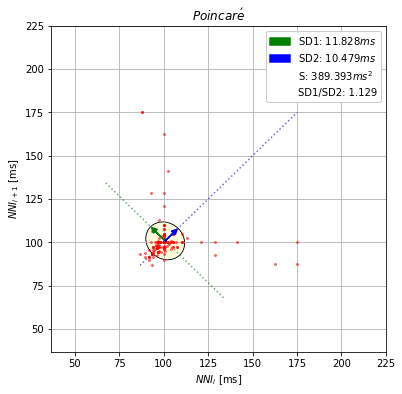

ReturnTuple(poincare_plot=<Figure size 432x432 with 1 Axes>, sd1=11.827901762100762, sd2=10.479249670108075, sd_ratio=0.885977063462425, ellipse_area=389.39266739267526)


In [58]:
# Estructuración de datos para Poincaré

min_c5 = [l.tolist() for l in tabulado_control5['mins']]
min_c5 = flatten(min_c5)

min_vk5 = [l.tolist() for l in tabulado_vk5['mins']]
min_vk5 = flatten(min_vk5)

min_dan5 = [l.tolist() for l in tabulado_dan5['mins']]
min_dan5 = flatten(min_dan5)

# Load sample data
nni = min_dan5

# Compute Poincaré using NNI series
results = nl.poincare(nni)

# Print SD1
print(results)

# results[0].savefig("c5.png")

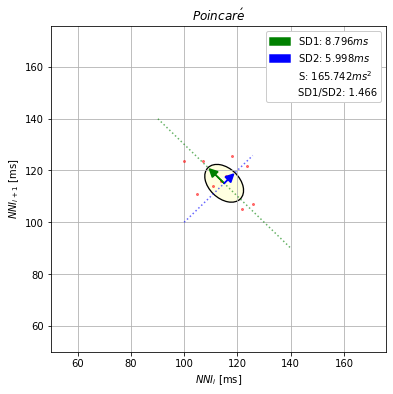

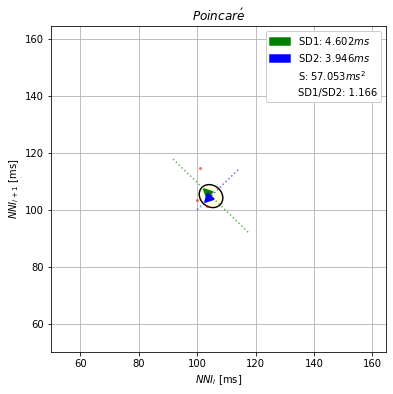

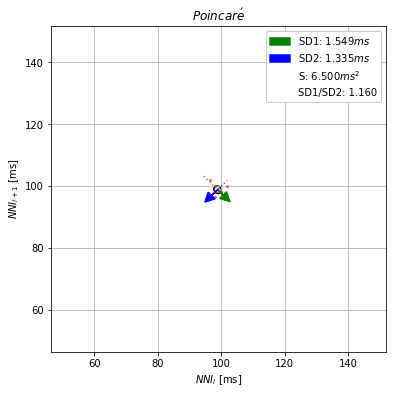

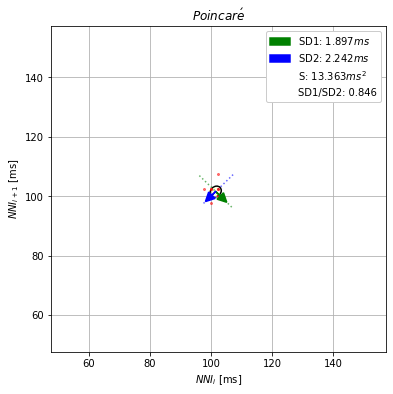

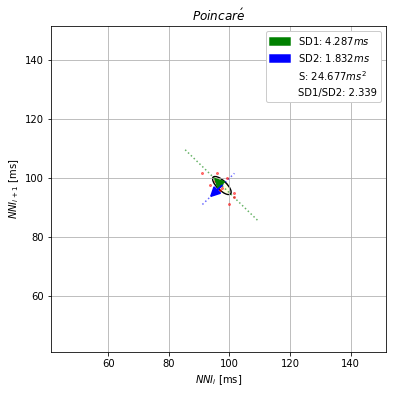

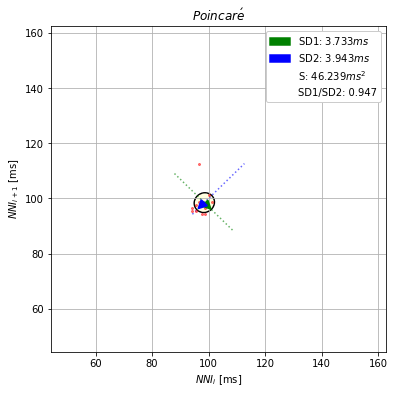

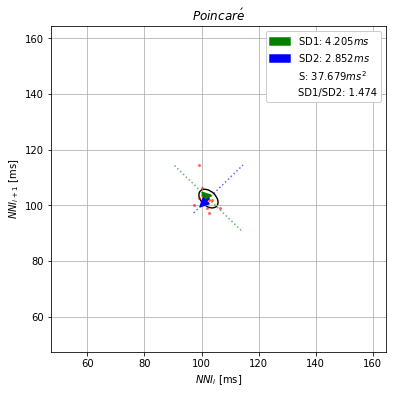

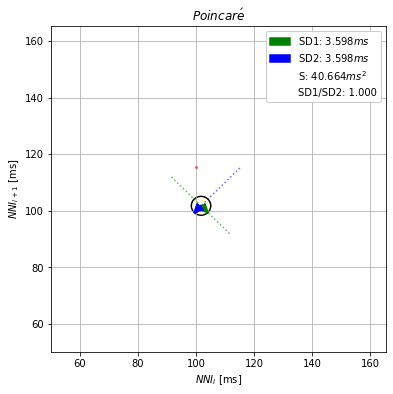

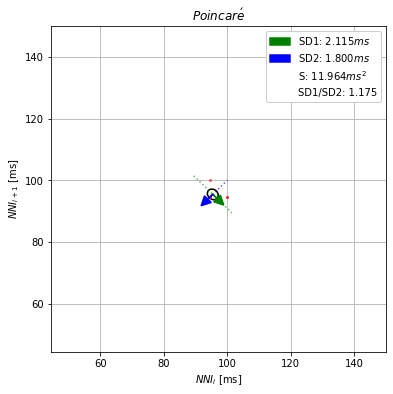

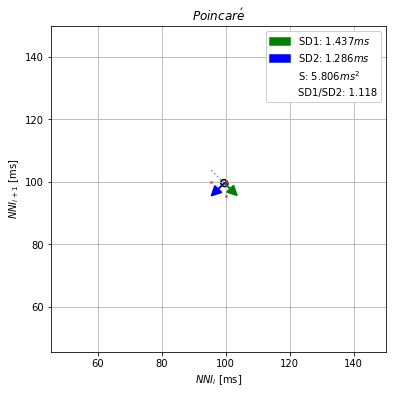

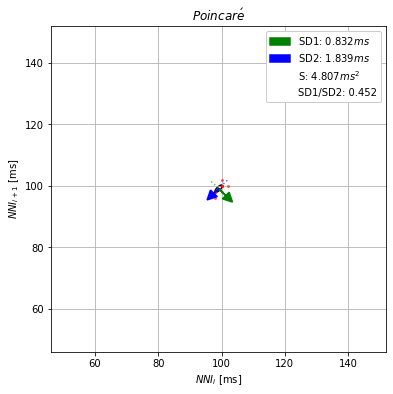

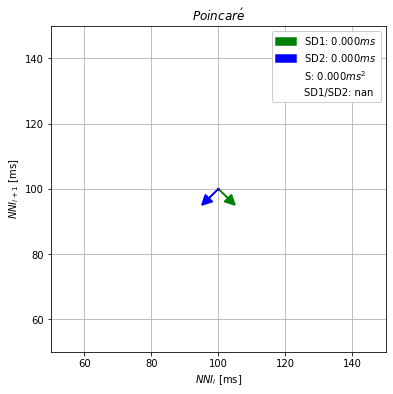

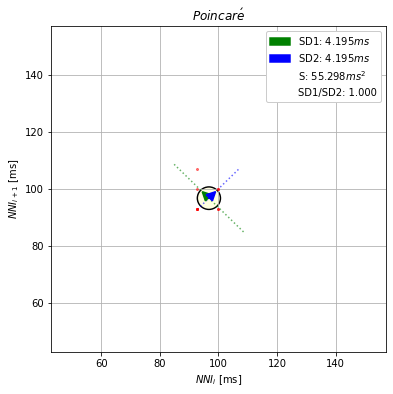

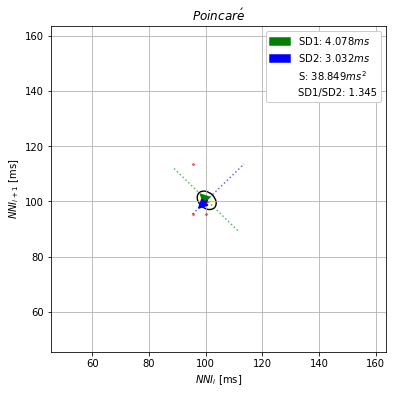

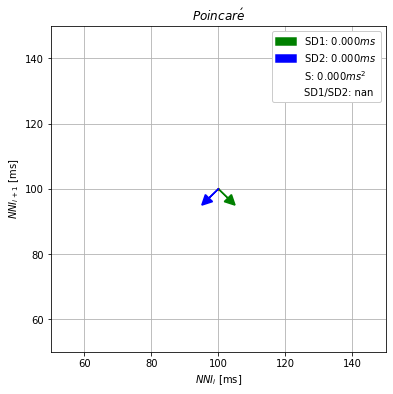

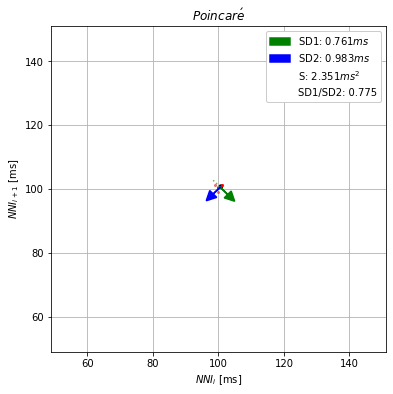

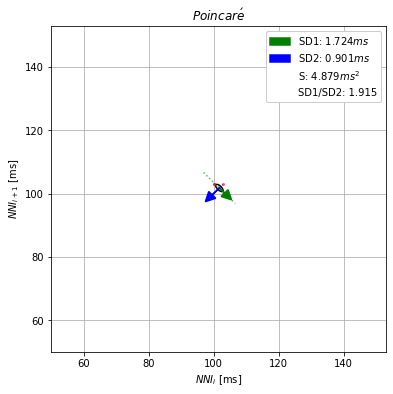

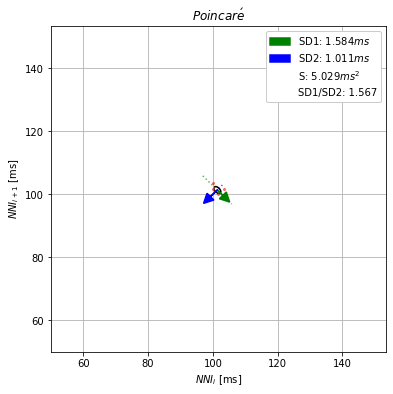

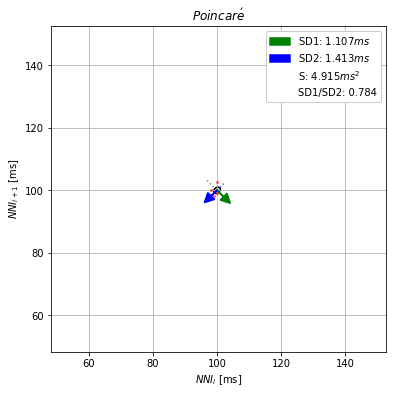

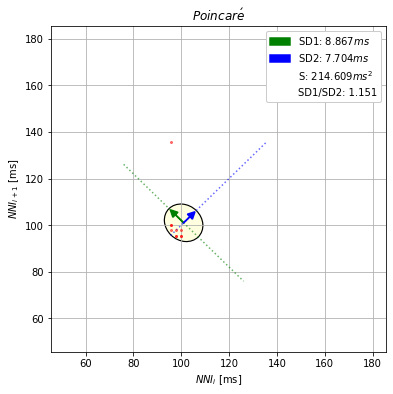

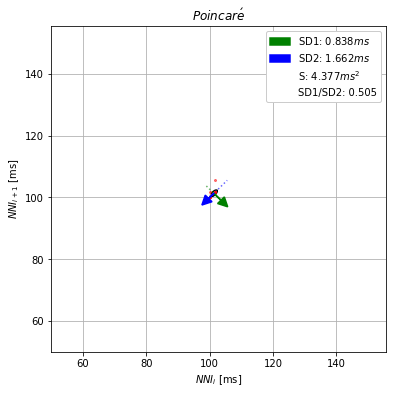

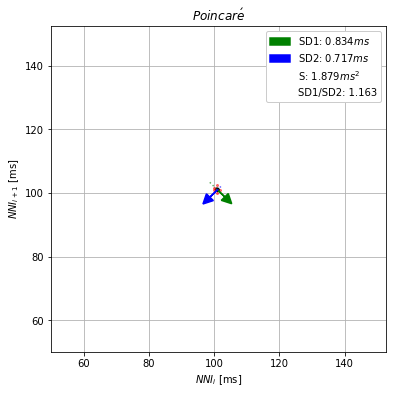

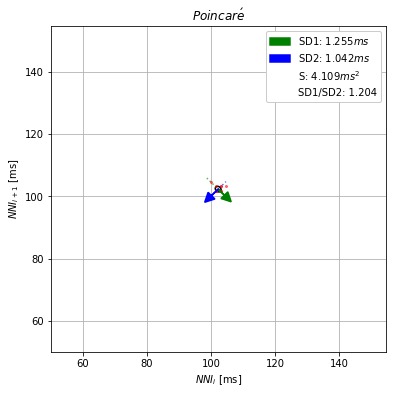

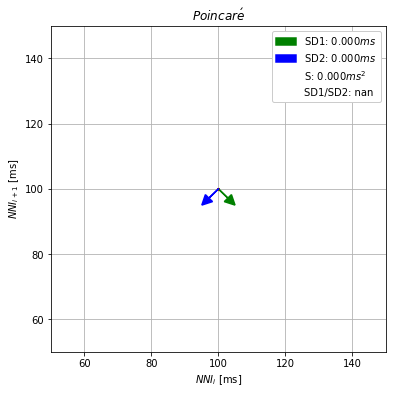

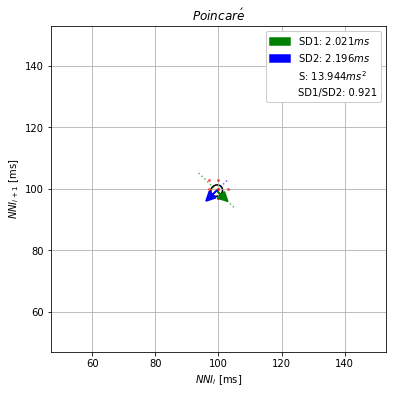

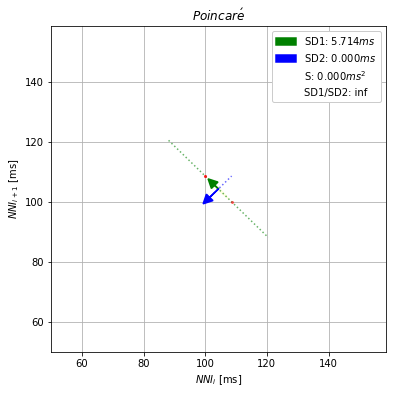

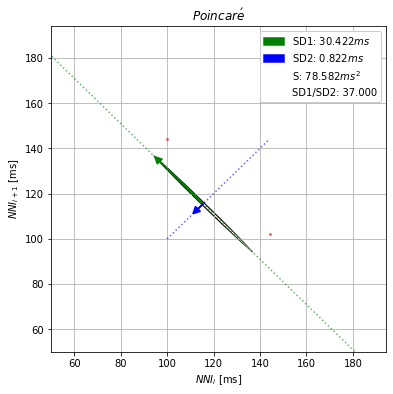

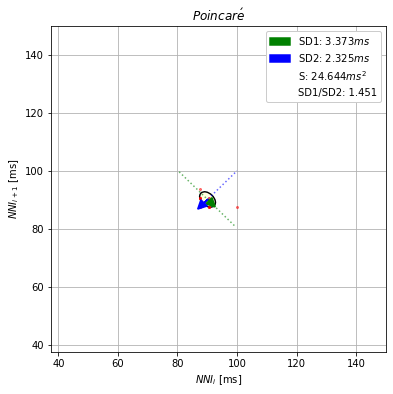

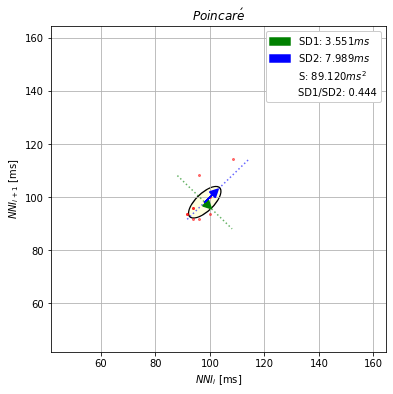

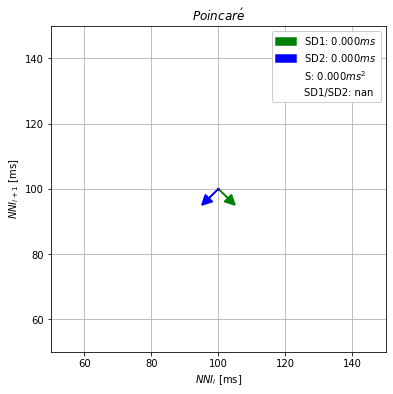

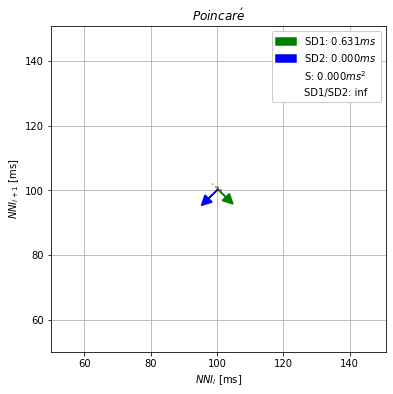

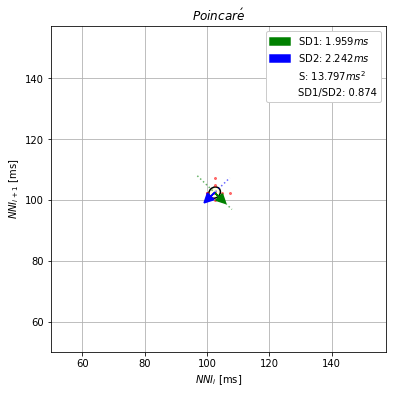

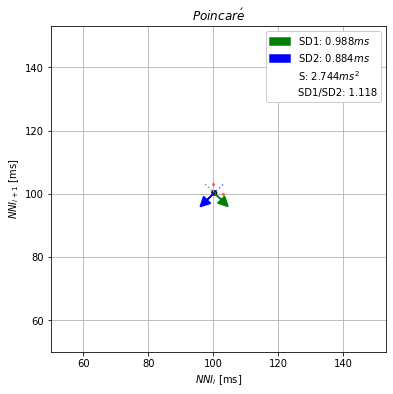

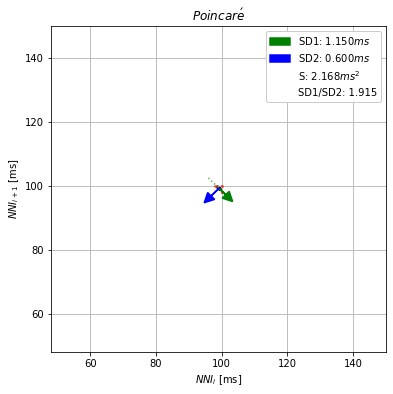

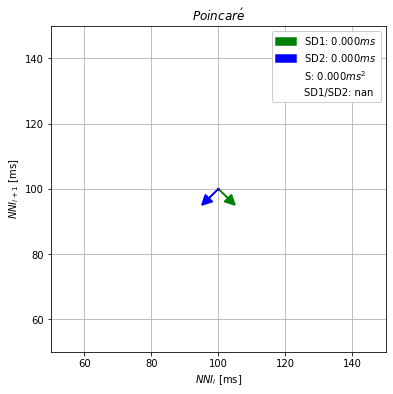

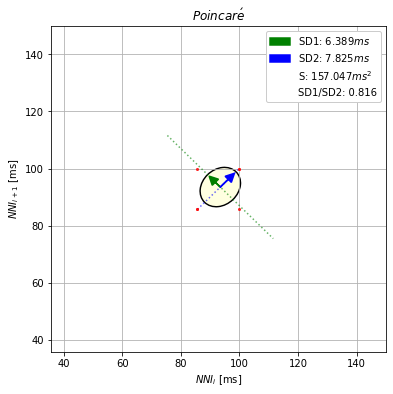

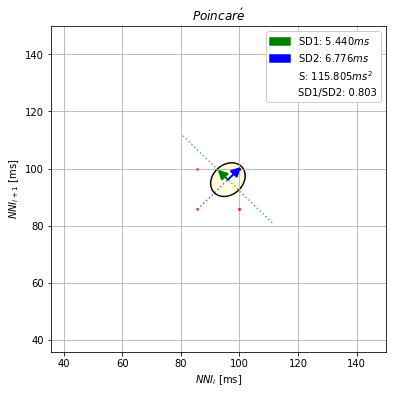

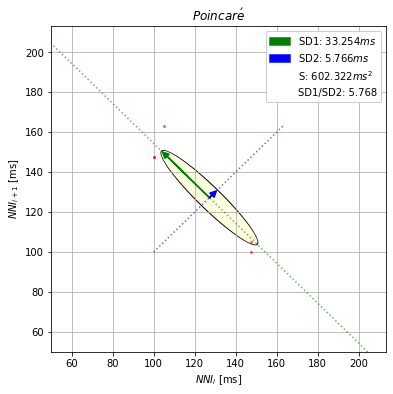

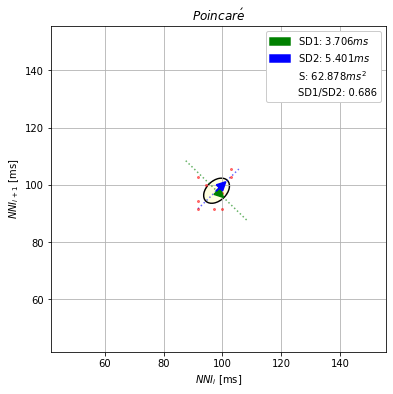

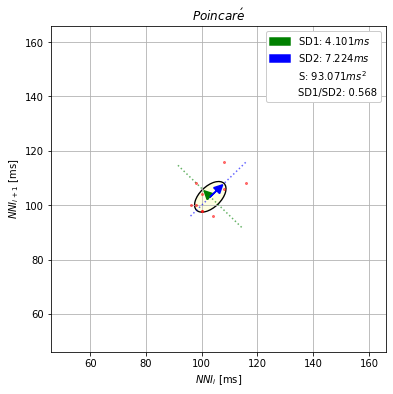

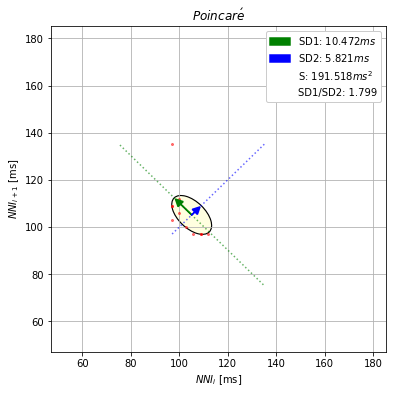

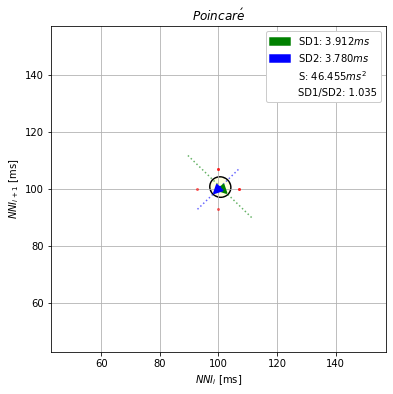

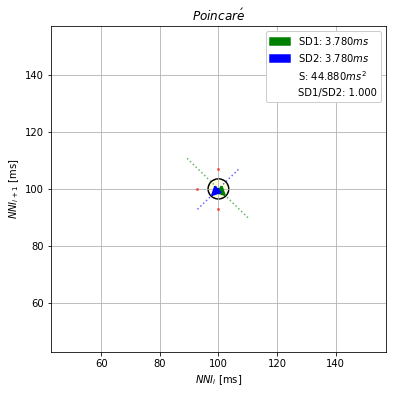

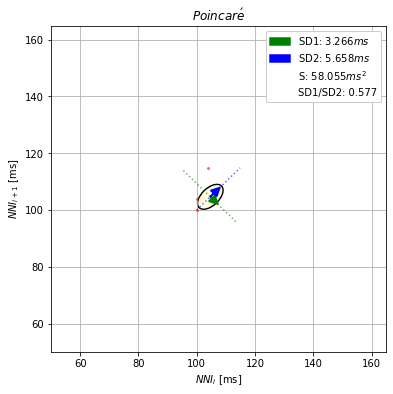

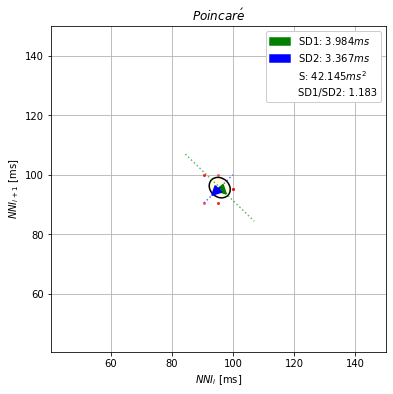

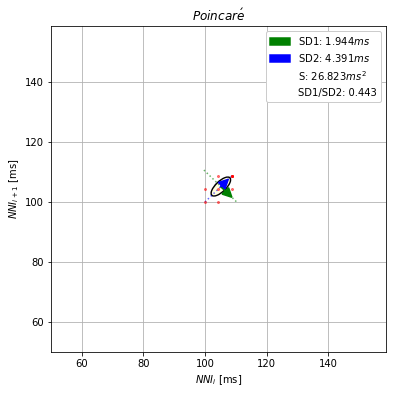

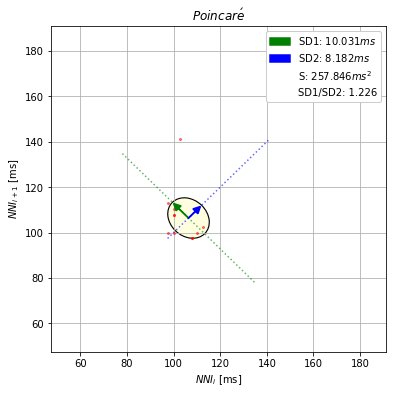

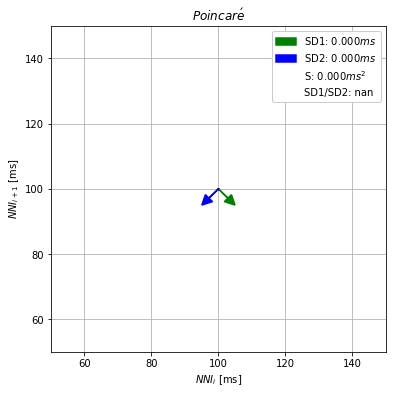

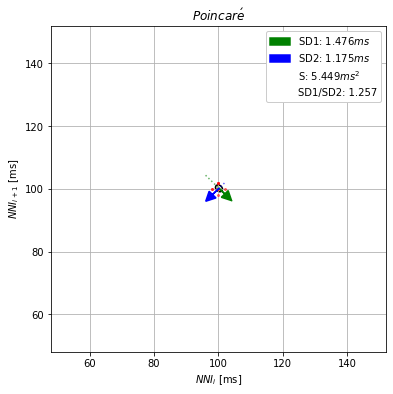

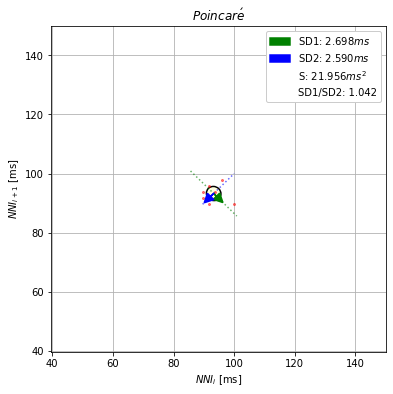

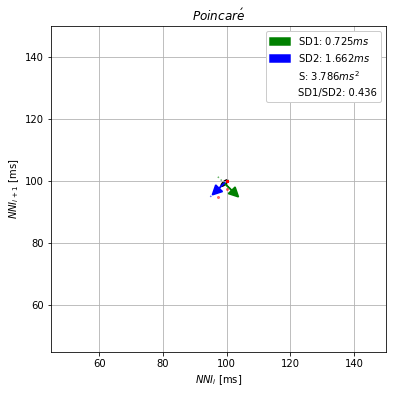

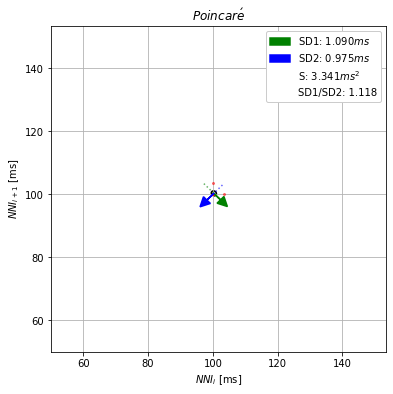

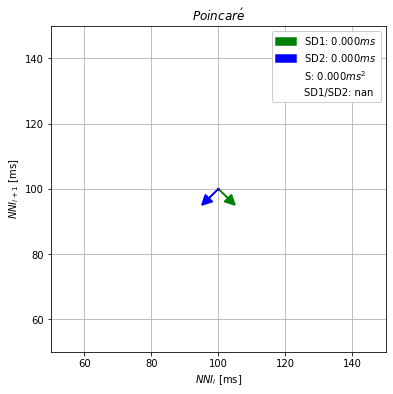

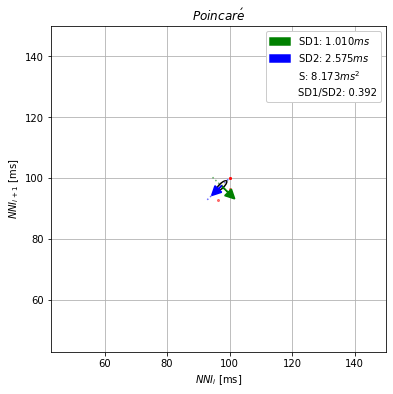

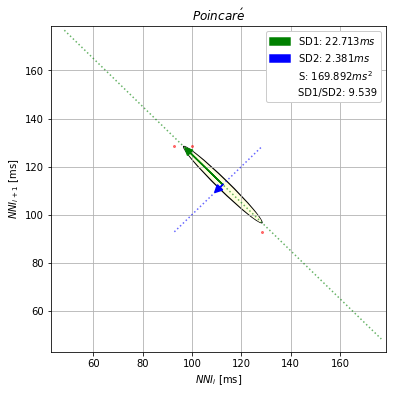

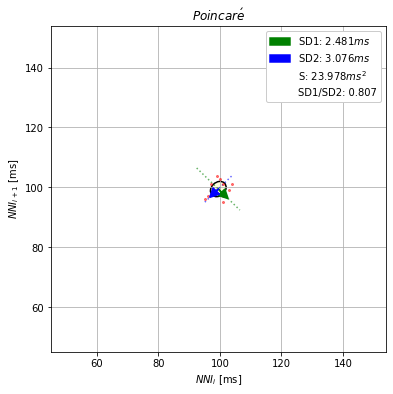

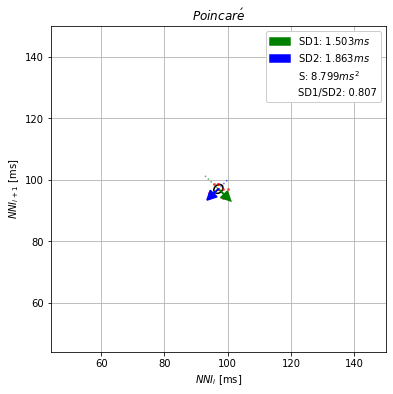

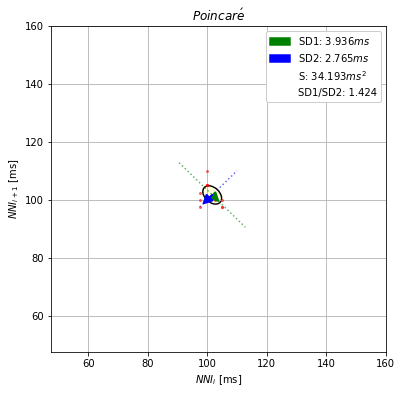

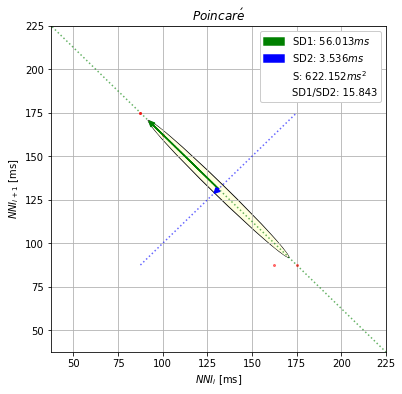

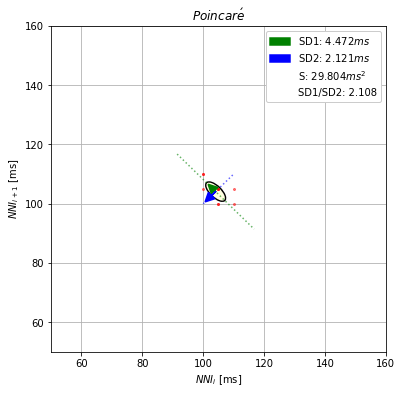

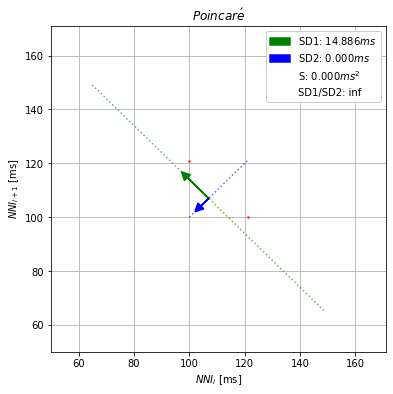

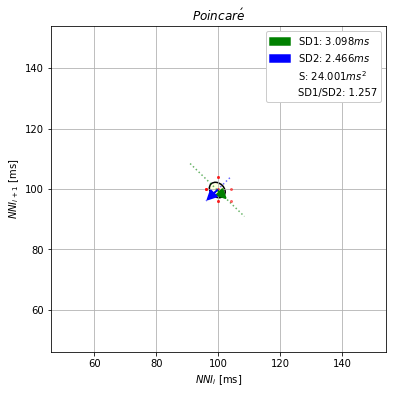

In [59]:
sd1 = []
sd2 = []
sd_ratio = []
for tabla in [tabulado_control5,tabulado_vk5,tabulado_dan5]:
    control_sd1 = []
    control_sd2 = []
    control_sd_ratio = []
    for i in range (len(tabla['mins'])):
        try:
            minimos = tabla['mins'][i]
            results = nl.poincare(minimos)
            control_sd1.append(results['sd1'])
            control_sd2.append(results['sd2'])
            control_sd_ratio.append(results[3])
        except:
            pass
    sd1.append(control_sd1)
    sd2.append(control_sd2)
    sd_ratio.append(control_sd_ratio)

In [74]:
for i in sd1:
    sd1_limpio = pd.DataFrame(i)[outliers(pd.DataFrame(i))]
    print(sd1_limpio.median(),sd1_limpio.std())

0    1.897116
dtype: float64 0    2.372746
dtype: float64
0    3.408603
dtype: float64 0    1.907377
dtype: float64
0    1.503312
dtype: float64 0    2.660989
dtype: float64


In [73]:
scipy.stats.kstest(sd2[0],sd2[1])

KstestResult(statistic=0.4523809523809524, pvalue=0.015139247872450579)

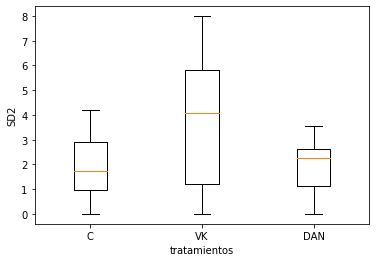

In [122]:
from matplotlib import pyplot

x = sd2[0]
y = sd2[1]
z = sd2[2]

fig = plt.figure()
pyplot.boxplot([x,y,z], 0,'')
pyplot.xlabel('tratamientos')
pyplot.xticks([1,2,3],['C','VK','DAN'])
pyplot.ylabel('SD2')
pyplot.show()
fig.savefig('SD2',dpi=300)

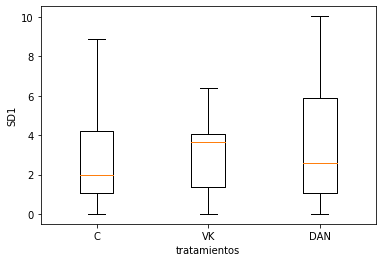

In [123]:
from matplotlib import pyplot

x = sd1[0]
y = sd1[1]
z = sd1[2]

fig = plt.figure()
pyplot.boxplot([x,y,z], 0,'')
pyplot.xlabel('tratamientos')
pyplot.xticks([1,2,3],['C','VK','DAN'])
pyplot.ylabel('SD1')
pyplot.show()
fig.savefig('SD1',dpi=300)